# Model Performance

In [1]:
# load libraries
import pandas as pd
import datetime as dt
import yfinance as yf
from numerapi import NumerAPI
from utils.api_keys import PUBLIC_ID, SECRET_KEY

In [2]:
# instantiate
TODAY = dt.datetime.now()
nmr = yf.download('NMR-USD', start=TODAY, end=TODAY)
napi = NumerAPI(public_id=PUBLIC_ID, secret_key=SECRET_KEY)

[*********************100%***********************]  1 of 1 completed


In [3]:
# get model performance history
def get_model_rankings(model_list):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.daily_model_performances(m))
        df['modelName'] = m
        df_list.append( df)
    df_all = pd.concat(df_list).set_index("date")
    return df_all

# plot model rankings
def plot_model_rankings(data, after_date, select_rank):
    data[after_date:].groupby('modelName')[select_rank].plot(
        y=select_rank,
        title=select_rank,
        figsize=(10, 3),
        legend=True,
        ylim=(10000, 0)
    );

# Current Staking Amount

In [4]:
# nmr price
nmr_price = nmr[['Open', 'High', 'Low', 'Close']].mean(axis=1)[0]
nmr_price

25.1072039604187

In [5]:
# get model names
model_list = napi.get_models().keys()
model_list

dict_keys(['dh_foxhound', 'dh_deadcell', 'dh_cobra', 'dh_beautybeast', 'dh_skulls', 'dh_desperado'])

In [6]:
# get current staking amount
for k in model_list:
    try:
        nmr_stake = round(float(napi.stake_get(k)), 2)
        nmr_usd = round(nmr_stake * nmr_price, 2)
        print(f"{k}: NMR{nmr_stake}, ${nmr_usd}")
    except:
        pass

dh_foxhound: NMR0.43, $10.8


# Model Performances

In [11]:
# get model rankings
perf = get_model_rankings(model_list=model_list)
perf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315 entries, 2022-04-27 00:00:00+00:00 to 2021-02-11 00:00:00+00:00
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   corrRank   315 non-null    float64
 1   corrRep    315 non-null    float64
 2   fncRank    315 non-null    float64
 3   fncRep     315 non-null    float64
 4   fncV3Rank  23 non-null     float64
 5   fncV3Rep   23 non-null     float64
 6   mmcRank    315 non-null    float64
 7   mmcRep     315 non-null    float64
 8   tcRank     108 non-null    float64
 9   tcRep      108 non-null    float64
 10  modelName  315 non-null    object 
dtypes: float64(10), object(1)
memory usage: 29.5+ KB


In [13]:
# date variable
AFTER_DATE = "2022-04-01"

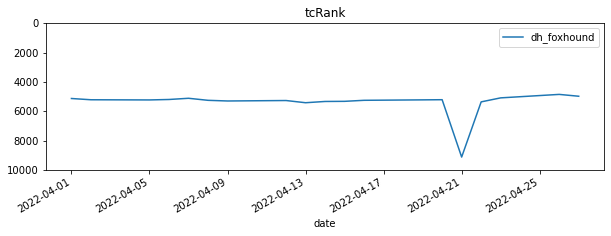

In [14]:
# plot model rankings
plot_model_rankings(
    data=perf,
    after_date=AFTER_DATE, 
    select_rank='tcRank'
)